In [1]:
from argon2 import hash_password_raw

from config import BASE_PATH, TRACKS_PER_FILE, NUM_FILES
from config import Config
from series_processing import process_series
from file_io import check_and_load_or_process
import numpy as np
import matplotlib.pyplot as plt
    

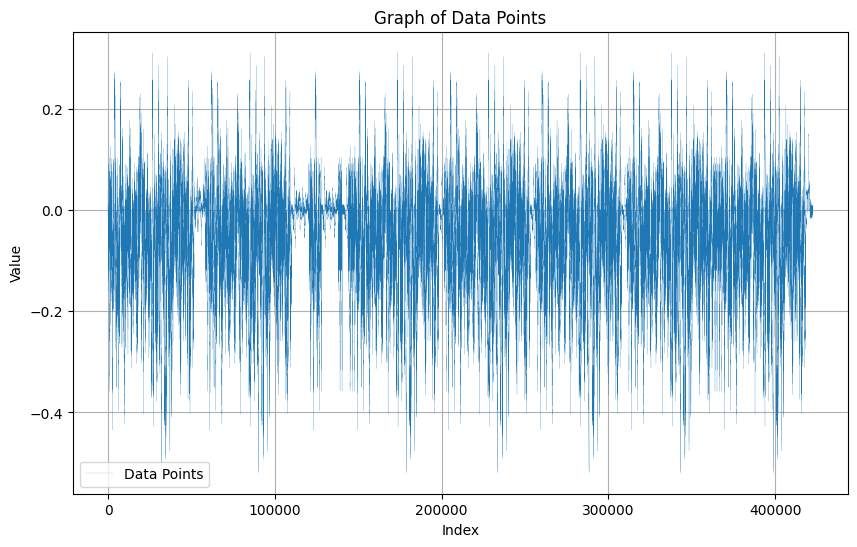

In [2]:

# Load data points from the text file
# Ensure your text file contains the data points as a single comma-separated line
file_path = r"C:\Users\Cole Thumann\Desktop\LabData\At_rest_points.txt"


# Read and process the file
with open(file_path, "r") as file:
    lines = file.readlines()

# Initialize a list to store all data points
data_points = []

# Process each group
for line in lines:
    line = line.strip()  # Remove any extra whitespace or newline characters
    if line:  # Skip empty lines
        # Split the line by commas and convert to floats
        group = [float(value.strip()) for value in line.split(",") if value.strip()]
        data_points.extend(group)

# Convert the cleaned data to a NumPy array
data_points = np.array(data_points)

# Generate the x-axis (index of the data points)
x = np.arange(len(data_points))

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(x, data_points, linewidth=.1, label="Data Points")
plt.title("Graph of Data Points")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()



In [3]:

LP_filename = r"C:\Users\Cole Thumann\Desktop\LabData\20241119\long-good-noise"
lp_offset = 54
HP_filename = r"C:\Users\Cole Thumann\Desktop\LabData\20241119\short-good-noise"
hp_offset = 13

traces_LP = check_and_load_or_process("", lp_offset, LP_filename, "Y", NUM_FILES)

traces_HP = check_and_load_or_process("",
        hp_offset, HP_filename, "X", NUM_FILES
    )

results_hp = []
results_lp = []
conf = 0

for trace in traces_HP:
    conf = Config(**trace['args'])
    result = process_series(trace['series'], conf)
    results_hp.append(result)
    
for trace in traces_LP:
    conf = Config(**trace['args'])
    result = process_series(trace['series'], conf)
    results_lp.append(result)


Processing data for 
Reading  C:\Users\Cole Thumann\Desktop\LabData\20241119\long-good-noise 0
data_col  Y
Reading  C:\Users\Cole Thumann\Desktop\LabData\20241119\long-good-noise 1
data_col  Y
Reading  C:\Users\Cole Thumann\Desktop\LabData\20241119\long-good-noise 2
data_col  Y
Reading  C:\Users\Cole Thumann\Desktop\LabData\20241119\long-good-noise 3
data_col  Y
Reading  C:\Users\Cole Thumann\Desktop\LabData\20241119\long-good-noise 4
data_col  Y
Reading  C:\Users\Cole Thumann\Desktop\LabData\20241119\long-good-noise 5
data_col  Y
Reading  C:\Users\Cole Thumann\Desktop\LabData\20241119\long-good-noise 6
data_col  Y
Reading  C:\Users\Cole Thumann\Desktop\LabData\20241119\long-good-noise 7
data_col  Y
Reading  C:\Users\Cole Thumann\Desktop\LabData\20241119\long-good-noise 8
data_col  Y
Reading  C:\Users\Cole Thumann\Desktop\LabData\20241119\long-good-noise 9
data_col  Y
Reading  C:\Users\Cole Thumann\Desktop\LabData\20241119\long-good-noise 10
data_col  Y
Reading  C:\Users\Cole Thumann\D

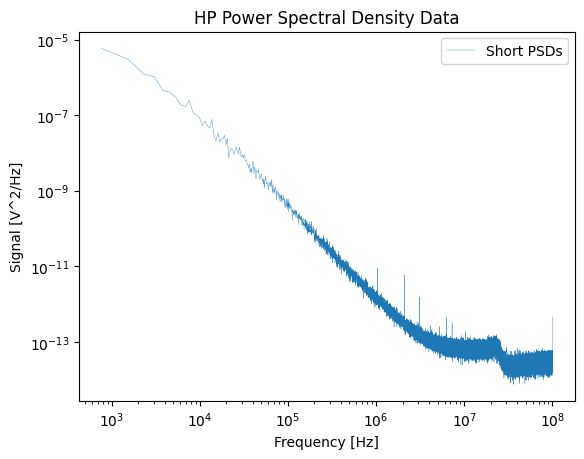

Text(0, 0.5, 'Signal [V^2/Hz]')

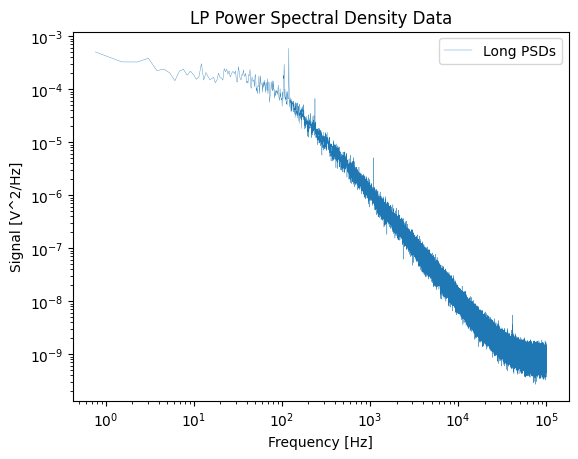

In [4]:

# Average the HP PSDs
hp_PSDs = np.array([item["psd"][1:-1] for item in results_hp])
hp_avg_psd = np.mean(hp_PSDs, axis=0)

lp_PSDs = np.array([item["psd"][1:-1] for item in results_lp])
lp_avg_psd = np.mean(lp_PSDs, axis=0)

freq_lp = results_lp[0]["frequency"][1:-1]
freq_hp = results_hp[0]["frequency"][1:-1]

plt.plot(freq_hp, hp_avg_psd, label="Short PSDs", linewidth=.25)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("HP Power Spectral Density Data")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Signal [V^2/Hz]")
plt.show()

plt.plot(freq_lp, lp_avg_psd, label="Long PSDs", linewidth=.25)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("LP Power Spectral Density Data")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Signal [V^2/Hz]")

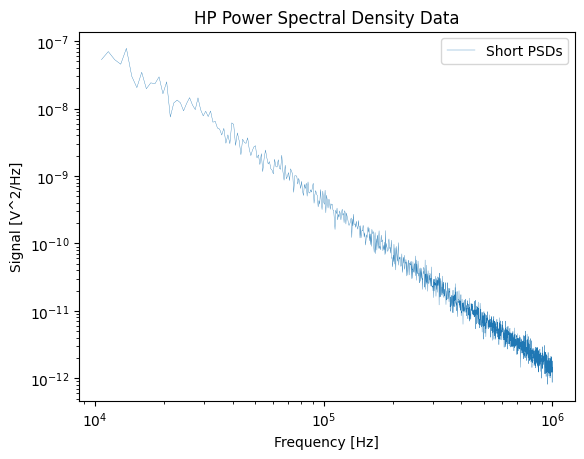

Text(0, 0.5, 'Signal [V^2/Hz]')

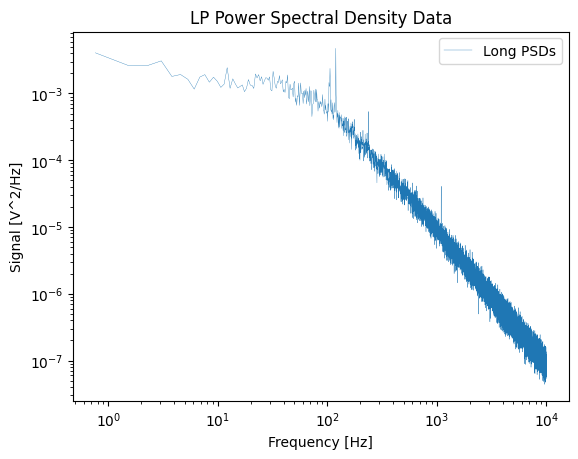

In [5]:
# CUT STUFF OUT

# cut the low power high f
mask = freq_lp <= 1e4
freq_lp = freq_lp[mask]
lp_avg_psd = lp_avg_psd[mask]

# cut the high power low f
mask = freq_hp >= 1e4
freq_hp = freq_hp[mask]
hp_avg_psd = hp_avg_psd[mask]

# cut the high power high f
mask = freq_hp <= 1e6
freq_hp = freq_hp[mask]
hp_avg_psd = hp_avg_psd[mask]

# cut the artifacts


#Multiply the lp by some factor
lp_avg_psd *=8


plt.plot(freq_hp, hp_avg_psd, label="Short PSDs", linewidth=.25)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("HP Power Spectral Density Data")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Signal [V^2/Hz]")
plt.show()

plt.plot(freq_lp, lp_avg_psd, label="Long PSDs", linewidth=.25)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("LP Power Spectral Density Data")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Signal [V^2/Hz]")

Text(0, 0.5, 'Signal [V^2/Hz]')

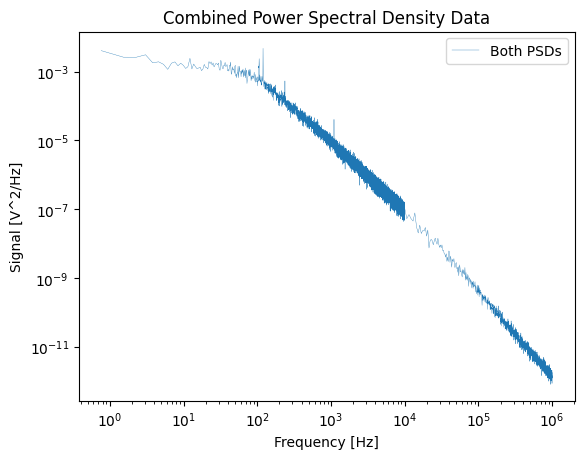

In [6]:
# Combine the psds together

freq_combined = np.concatenate((freq_lp, freq_hp))
psd_combined = np.concatenate((lp_avg_psd, hp_avg_psd))

# Sort the combined arrays by frequency
sorted_indices = np.argsort(freq_combined)
freq_combined = freq_combined[sorted_indices]
psd_combined = psd_combined[sorted_indices]

plt.plot(freq_combined, psd_combined, label="Both PSDs", linewidth=.25)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("Combined Power Spectral Density Data")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Signal [V^2/Hz]")

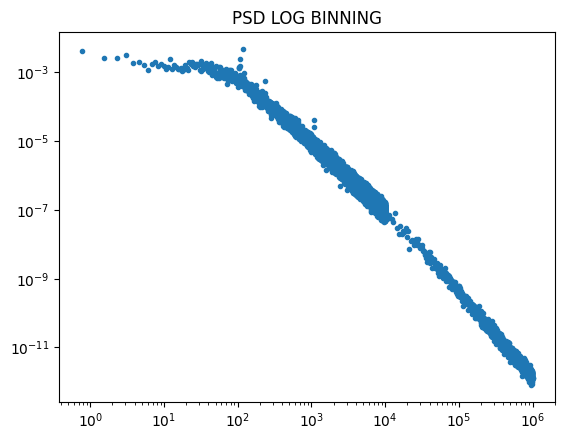

In [7]:
# Fit the combined PSD
from fitting import log_bin_array, PSD_fitting, PSD_fitting_func

# freqs, PSD = log_bin_array(freq_combined, psd_combined, 5, 2e6, 200)
freqs, PSD = freq_combined, psd_combined

plt.plot(freqs, PSD, ".")
plt.title("PSD LOG BINNING")
plt.xscale("log")
plt.yscale("log")
plt.show()

True CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Parameters =  [1.00000000e-15 3.32851305e-05 1.00000000e+07]


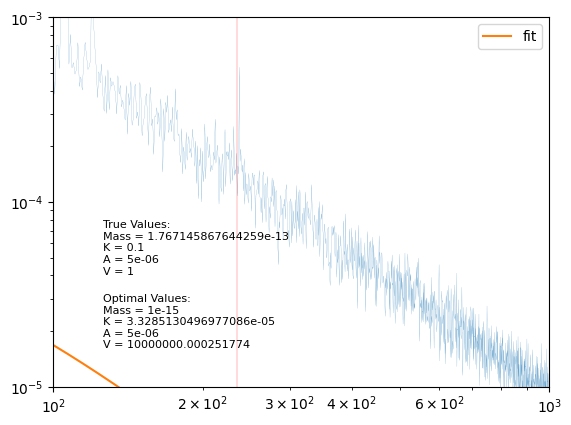

In [8]:
from fitting import log_bin_array, PSD_fitting, PSD_fitting_func

a_guess = 5e-6
v_guess = 1e7
m_guess = 1e-13
k_guess = 5e-7

# bounds = [(a_guess, a_guess), (m_guess, m_guess), (k_guess, k_guess), (v_guess, v_guess)]

optimal_parameters = PSD_fitting(freqs, PSD, a_guess, m_guess, k_guess, v_guess)
optimal_parameters.x[0] = optimal_parameters.x[0]*1e-14
PSD_fit = PSD_fitting_func(freqs * 2 * np.pi, optimal_parameters.x[0], optimal_parameters.x[1], a_guess, optimal_parameters.x[2])

print("Parameters = ", optimal_parameters.x)
plt.text(0.1, 0.1, f"Optimal Values:\nMass = {optimal_parameters.x[0]}\nK = {optimal_parameters.x[1]}\nA = {a_guess}\nV = {optimal_parameters.x[2]}",
         fontsize=8, ha='left', va='bottom', transform=plt.gca().transAxes)
plt.text(0.1, 0.3, f"True Values:\nMass = {conf.mass_total}\nK = {.1}\nA = {conf.a}\nV = {1}",
         fontsize=8, ha='left', va='bottom', transform=plt.gca().transAxes)

plt.plot(freqs[1:], PSD[1:], linewidth = .1)

# plt.axhline(2*const.k_b*conf.temp*config.gamma/k_guess**2)

plt.plot(freqs[1:], PSD_fit[1:], label="fit")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlim(left=1e2, right=1e3)
plt.ylim(bottom=1e-5, top=1e-3)
plt.axvline(2.35e2, linewidth=.2, color='r')
plt.show()


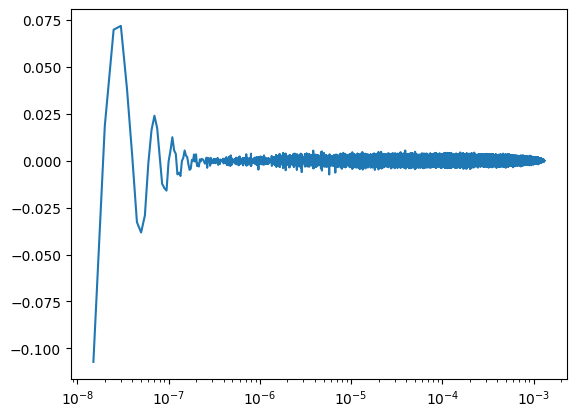

In [9]:
# Average the HP VACFs
vacf_ = np.array([item["v_acf"] for item in results_hp])
vacf = np.mean(vacf_, axis=0)
    
hp_times = results_hp[0]["time"]

plt.plot(hp_times[3:], vacf[2:])
plt.xscale("log")
plt.show()